**Instructions to connect local runtime**

Step 1: Install [Jupyter](https://jupyter.org/install) on your local machine. (one-time)

Step 2: Install and enable the `jupyter_http_over_ws` jupyter extension (one-time)
```
> pip install jupyter_http_over_ws
> jupyter serverextension enable --py jupyter_http_over_ws
```
Step 3: Start server and authenticate
```
> jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```
Click the "Connect" button and select "Connect to local runtime...". Enter the port from the previous step in the dialog that appears and click the "Connect" button. After this, you should now be connected to your local runtime.



**Libraries**

In [1]:
# Basic libraries
import numpy as np
import pandas as pd

# Natural Language Processing
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer= PorterStemmer()
lemmatizer=WordNetLemmatizer()

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Modeling
import sklearn.ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix,roc_curve,auc
from imblearn.over_sampling import SMOTE

[nltk_data] Downloading package stopwords to C:\Users\Nishan
[nltk_data]     Chathuranga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Nishan
[nltk_data]     Chathuranga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Nishan
[nltk_data]     Chathuranga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Load Data**

In [2]:
# News Data
url_news = 'data/FakeNews/ira_venezuela_tweets_not_hashed.csv'

df_news = pd.read_csv(url_news, index_col=0, encoding='utf8')

# **Fake News (News Credibility)**

In [3]:
df_news.head(5)

,text,credible
0,#local #news Volunteers clean 9 tons of trash ...,0
1,The Doctor Is In: Increased vaping among teens...,0
2,"Ex-lawmaker arraigned, governor seeks to comba...",0
3,Tony-winning 'Cheers' actor Roger Rees dies #...,0
4,Manager Lloyd McClendon’s status at top of new...,0


In [4]:
df_news.tail(5)

,text,credible
23995,EU escalates action on ‘unfair’ German and UK ...,1
23996,2 dead in Christmas night shooting in Chicago ...,1
23997,Fish rescued while trying to swim up street af...,1
23998,The way your wash your hands could be leaving ...,1
23999,"After 25 years, Berkeley Breathed's 'Bloom Cou...",1


In [5]:
df_news.rename(columns={'text': 'title'}, inplace=True)

**Clean News Data**

In [6]:
def clean_data(dataframe):
    # Drop duplicate rows
    dataframe.drop_duplicates(subset='title', inplace=True)

    # Remove punctation
    dataframe['title'] = dataframe['title'].str.replace('[^\w\s]',' ')

    # Remove numbers 
    dataframe['title'] = dataframe['title'].str.replace('[^A-Za-z]',' ')

    # Make sure any double-spaces are single 
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')
    dataframe['title'] = dataframe['title'].str.replace('  ',' ')

    # Transform all text to lowercase
    dataframe['title'] = dataframe['title'].str.lower()
    
    print("New shape:", dataframe.shape)
    return dataframe.head()

In [7]:
clean_data(df_news)

New shape: (23113, 2)


,title,credible
0,local news volunteers clean tons of trash out...,0
1,the doctor is in increased vaping among teens ...,0
2,ex lawmaker arraigned governor seeks to combat...,0
3,tony winning cheers actor roger rees dies ente...,0
4,manager lloyd mcclendon s status at top of new...,0


In [8]:
# Set variables to show TheOnion Titles
mask_on = df_news['credible'] == 1
df_news_not_credible_titles = df_news[mask_on]['title']

# Instantiate a CountVectorizer
cv1 = CountVectorizer(stop_words = 'english')

news_not_credible_cvec = cv1.fit_transform(df_news_not_credible_titles.values.astype('U'))

# Convert onion_cvec into a DataFrame
news_not_credible_cvec_df = pd.DataFrame(news_not_credible_cvec.toarray(),
                   columns=cv1.get_feature_names())

# Inspect head of Onion Titles cvec
print(news_not_credible_cvec_df.shape)

(11662, 23998)


In [9]:
# Instantiate a CountVectorizer
cv2 = CountVectorizer(stop_words = 'english', ngram_range=(2,2))

news_not_credible_cvec_bi = cv2.fit_transform(df_news_not_credible_titles.values.astype('U'))

# Convert onion_cvec into a DataFrame
news_not_credible_cvec_df_bi = pd.DataFrame(news_not_credible_cvec_bi.toarray(),
                   columns=cv2.get_feature_names())

# Inspect head of Onion Titles cvec
print(news_not_credible_cvec_df_bi.shape)

(11662, 84515)


In [10]:
# Set variables to show NotTheOnion Titles
mask_no = df_news['credible'] == 0
df_news_credible_titles = df_news[mask_no]['title']

# Instantiate a CountVectorizer
cv3 = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
news_credible_cvec = cv3.fit_transform(df_news_credible_titles.values.astype('U'))

# Convert onion_cvec into a DataFrame
news_credible_cvec_df = pd.DataFrame(news_credible_cvec.toarray(),
                   columns=cv3.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(news_credible_cvec_df.shape)

(11451, 24551)


In [11]:
# Instantiate a CountVectorizer
cv4 = CountVectorizer(stop_words = 'english' , ngram_range=(2,2))

# Fit and transform the vectorizer on our corpus
news_credible_cvec_bi = cv4.fit_transform(df_news_credible_titles.values.astype('U'))

# Convert onion_cvec into a DataFrame
news_credible_cvec_df_bi = pd.DataFrame(news_credible_cvec_bi.toarray(),
                   columns=cv4.get_feature_names())

# Inspect head of Not Onion Titles cvec
print(news_credible_cvec_df_bi.shape)

(11451, 77172)


In [12]:
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(9,5))
    g=sns.barplot(x, y, color = color)    
    ax=g

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # Enable bar values
    # Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for p in ax.patches:
        totals.append(p.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38, \
                int(p.get_width()), fontsize=10)

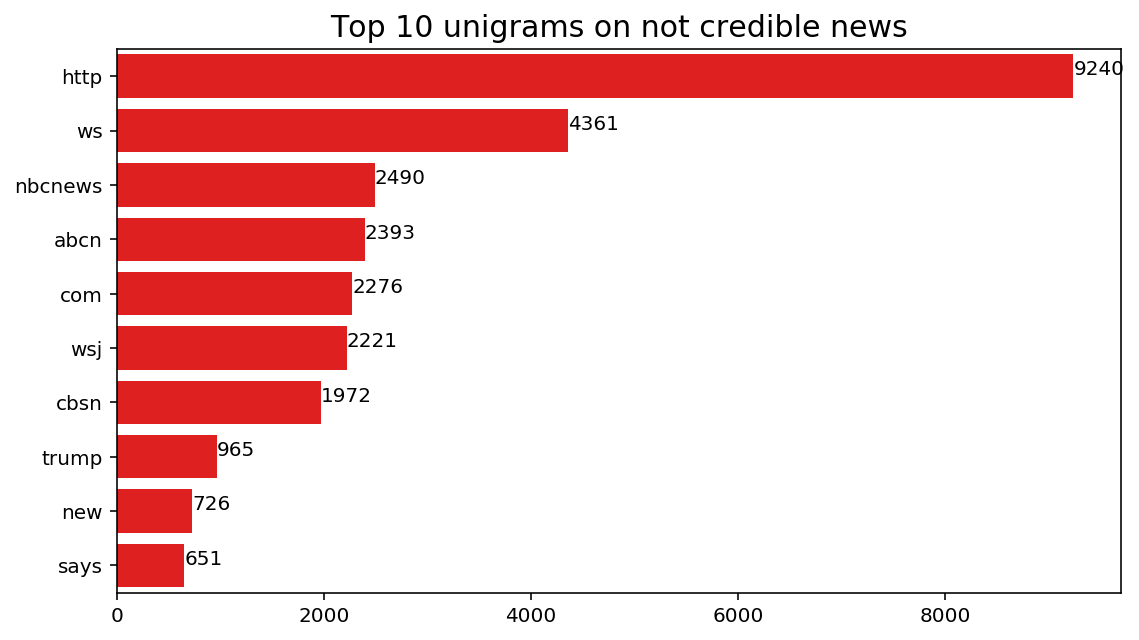

In [13]:
# Set up variables to contain top 10 most used words in Onion
news_not_credible_wc = news_not_credible_cvec_df.sum(axis = 0)
news_not_credible_top_10 = news_not_credible_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_not_credible_top_10.values, news_not_credible_top_10.index, 'Top 10 unigrams on not credible news','r') 



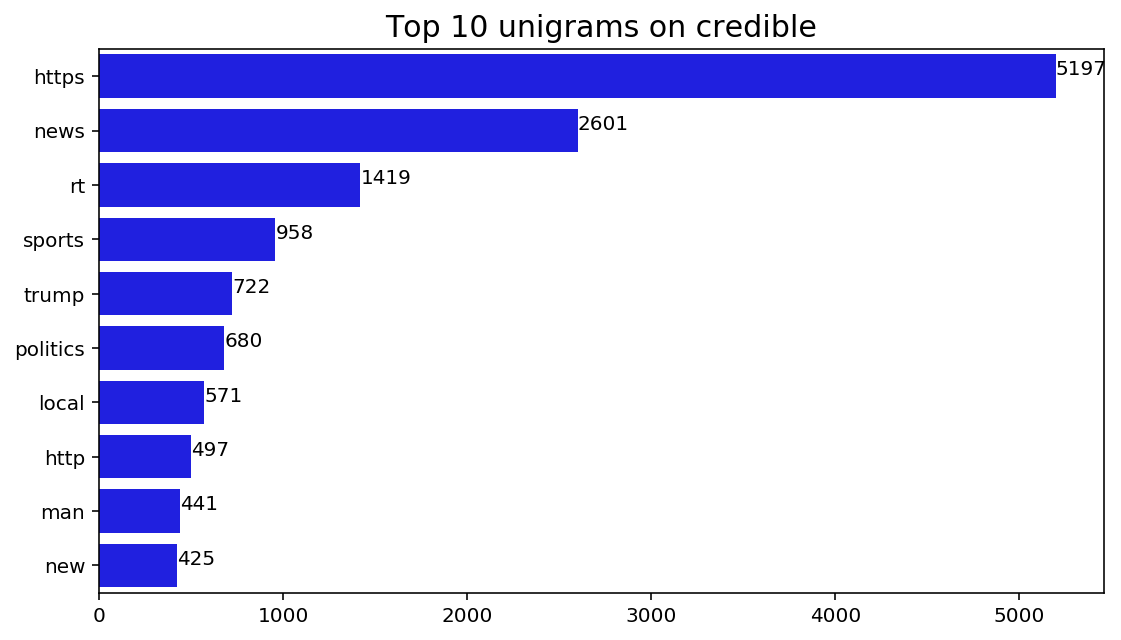

In [14]:
# Set up variables to contain top 10 most used words in Onion
news_credible_wc = news_credible_cvec_df.sum(axis = 0)
news_credible_top_10 = news_credible_wc.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_credible_top_10.values, news_credible_top_10.index, 'Top 10 unigrams on credible','b') 

In [15]:
# Create list of unique words in top five
news_credible_10_set = set(news_credible_top_10.index)
news_not_credible_10_set = set(news_not_credible_top_10.index)

# Return common words
common_unigrams = news_not_credible_10_set.intersection(news_credible_10_set)
common_unigrams

{'http', 'new', 'trump'}

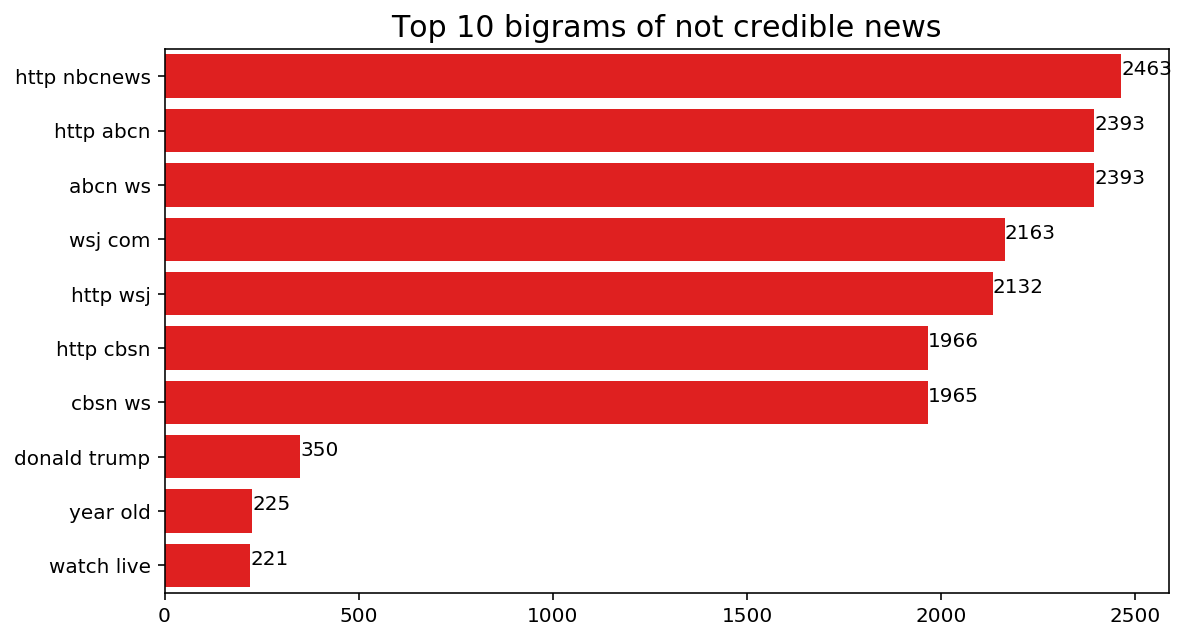

In [16]:
# Set up variables to contain top 10 most used words in Onion
news_not_credible_wc_bi = news_not_credible_cvec_df_bi.sum(axis = 0)
news_not_credible_top_10_bi = news_not_credible_wc_bi.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_not_credible_top_10_bi.values, news_not_credible_top_10_bi.index, 'Top 10 bigrams of not credible news','r') 

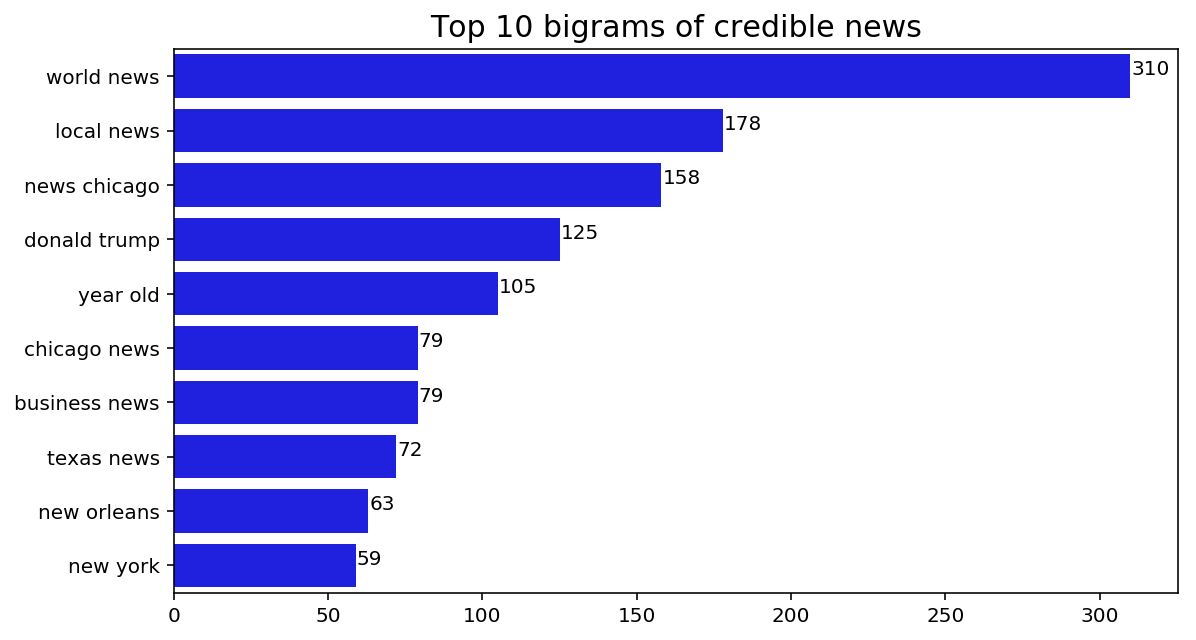

In [17]:
# Set up variables to contain top 10 most used words in Onion
news_credible_wc_bi = news_credible_cvec_df_bi.sum(axis = 0)
news_credible_top_10_bi = news_credible_wc_bi.sort_values(ascending=False).head(10)

# Call function
bar_plot(news_credible_top_10_bi.values, news_credible_top_10_bi.index, 'Top 10 bigrams of credible news','b') 

In [18]:
news_credible_10_list = set(news_credible_top_10_bi.index)
news_not_credible_10_list = set(news_not_credible_top_10_bi.index)

# Return common words
common_bigrams = news_credible_10_list.intersection(news_not_credible_10_list)
common_bigrams

{'donald trump', 'year old'}

**Create custom stop_words to include common frequent words**

In [19]:
# Create lists 
custom = stop_words.ENGLISH_STOP_WORDS
custom = list(custom)
common_unigrams = list(common_unigrams)
common_bigrams = list(common_bigrams)

# Append unigrams to list 
for i in common_unigrams:
    custom.append(i)

# Append bigrams to list 
for i in common_bigrams:
    split_words = i.split(" ")
    for word in split_words:
        custom.append(word)

In [20]:
# Baseline score
df_news['credible'].value_counts(normalize=True)

1    0.504565
0    0.495435
Name: credible, dtype: float64

In [21]:
df_news['title'].dropna()

0         local news volunteers clean tons of trash out...
1        the doctor is in increased vaping among teens ...
2        ex lawmaker arraigned governor seeks to combat...
3        tony winning cheers actor roger rees dies ente...
4        manager lloyd mcclendon s status at top of new...
                               ...                        
23995    eu escalates action on unfair german and uk ro...
23996     dead in christmas night shooting in chicago h...
23997    fish rescued while trying to swim up street af...
23998    the way your wash your hands could be leaving ...
23999    after years berkeley breathed s bloom county c...
Name: title, Length: 23112, dtype: object

**Set X (predictor) and y (target) variables**

In [22]:
X = df_news['title']
y = df_news['credible']

**Train/Test Split**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

**CountVectorizer & MultinomialNB (Best Accuracy Score)**

In [24]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'cvec__ngram_range': [(1,1),(1,3)],
               'nb__alpha': [.36, .6]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train.astype('U'), y_train.astype('U'));
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train.values.astype('U'), y_train.values.astype('U')))
print("Test score", gs.score(X_test.values.astype('U'), y_test.values.astype('U')))

gs.best_params_

Best score: 0.9450213453328719
Train score 0.983327564324449
Test score 0.9510295898944454


{'cvec__ngram_range': (1, 1), 'nb__alpha': 0.6}

**CountVectorizer & MultinomialNB: Best Params**

In [25]:
#Instantiate the classifier and vectorizer
nb = MultinomialNB(alpha = 0.36)
cvec = CountVectorizer(ngram_range= (1, 3))

# Fit and transform the vectorizor
cvec.fit(X_train.values.astype('U'))

Xcvec_train = cvec.transform(X_train.values.astype('U'))
Xcvec_test = cvec.transform(X_test.values.astype('U'))

# Fit the classifier
nb.fit(Xcvec_train,y_train)

# Create the predictions for Y training data
preds = nb.predict(Xcvec_test)

print(nb.score(Xcvec_test, y_test))

0.936667243467728


**Confusion Matrix**

In [26]:
# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, preds)
cnf_matrix

array([[2593,  270],
       [  96, 2820]], dtype=int64)

Text(0.5,257.44,'Predicted label')

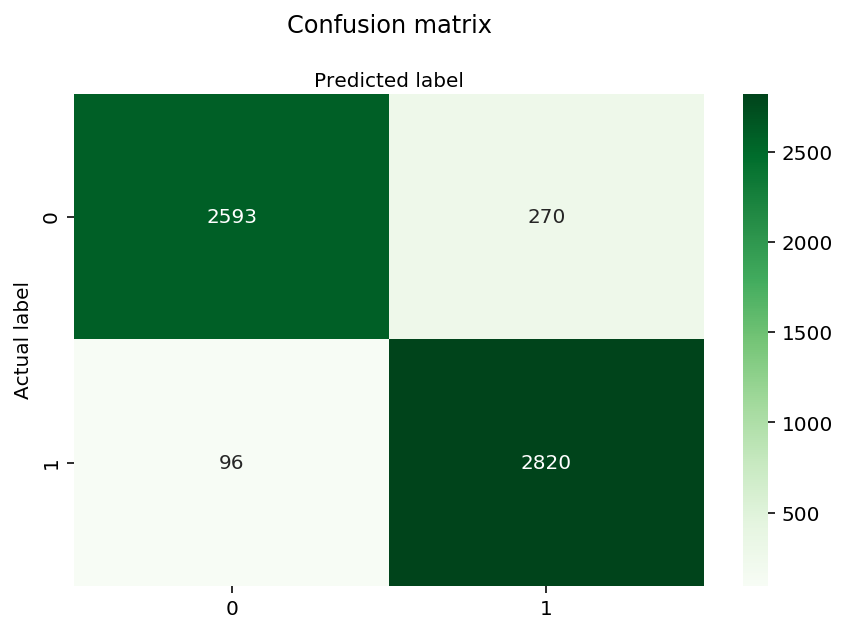

In [27]:
# Code from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# name  of classes
class_names=[0,1] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Greens" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [28]:
# Assign True Neg, False Pos, False Neg, True Pos variables
cnf_matrix = np.array(cnf_matrix).tolist()

tn_fp, fn_tp = cnf_matrix

tn, fp = tn_fp
fn, tp = fn_tp

**Conclusion 1** - **Accuracy Scores**

In [29]:
# Print Scores 
print("Accuracy:",round(metrics.accuracy_score(y_test, preds)*100, 2),'%')
print("Precision:",round(metrics.precision_score(y_test, preds)*100, 2), '%')
print("Recall:",round(metrics.recall_score(y_test, preds)*100, 2), '%')
print("Specificity:", round((tn/(tn+fp))*100, 2), '%')
print("Misclassification Rate:", round((fp+fn)/(tn+fp+fn+tn)*100, 2), '%')

Accuracy: 93.67 %
Precision: 91.26 %
Recall: 96.71 %
Specificity: 90.57 %
Misclassification Rate: 6.59 %


**CountVectorizer & Logistic Regression** : Best Coefficient Interpretability

In [32]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english', custom],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train.values.astype('U'), y_train.values.astype('U'));
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train.values.astype('U'), y_train.values.astype('U')))
print("Test score", gs.score(X_test.values.astype('U'), y_test.values.astype('U')))

gs.best_params_

Best score: 0.9720203069112726
Train score 0.9979808468905043
Test score 0.9731787506489012


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 1}

In [33]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec2 = CountVectorizer(stop_words = custom)

# Fit and transform the vectorizor
cvec2.fit(X_train.values.astype('U'))

Xcvec2_train = cvec2.transform(X_train.values.astype('U'))
Xcvec2_test = cvec2.transform(X_test.values.astype('U'))

# Fit the classifier
lr.fit(Xcvec2_train,y_train)

# Create the predictions for Y training data
lr_preds = lr.predict(Xcvec2_test)

print(lr.score(Xcvec2_test, y_test))

0.9634884928188268


In [34]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98, 1.0],
               'tvect__min_df': [2, 3, 5],
               'tvect__ngram_range': [(1,1), (1,2), (1,3)],
               'lr__C': [1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3)
gs.fit(X_train.values.astype('U'), y_train.values.astype('U'));
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train.values.astype('U'), y_train.values.astype('U')))
print("Test score", gs.score(X_test.values.astype('U'), y_test.values.astype('U')))

gs.best_params_

Best score: 0.9630783431406484
Train score 0.9847121264566747
Test score 0.9671223395051047


{'lr__C': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 5,
 'tvect__ngram_range': (1, 1)}

In [35]:
pipe = Pipeline([('tvect', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'tvect__max_df': [.75, .98],
               'tvect__min_df': [4, 5],
               'tvect__ngram_range': [(1,2), (1,3)],
               'nb__alpha': [0.1, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train.values.astype('U'), y_train.values.astype('U'));
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train.values.astype('U'), y_train.values.astype('U')))
print("Test score", gs.score(X_test.values.astype('U'), y_test.values.astype('U')))

gs.best_params_

Best score: 0.9473289488865813
Train score 0.9692511826468213
Test score 0.9480879044817443


{'nb__alpha': 1,
 'tvect__max_df': 0.75,
 'tvect__min_df': 5,
 'tvect__ngram_range': (1, 2)}

**Coefficient Analysis**

In [ ]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec2.get_feature_names(), columns = ["penalized_regression_coefficients"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# Jasmine changing things up here on out! Top half not mine. 
# create best and worst performing lasso coef dataframes
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients', size=14)
ax = sns.barplot(x = 'penalized_regression_coefficients', y= df_merged.index, 
data=df_merged)
ax.set(xlabel='Penalized Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [ ]:
print("The word that contributes the most positively to being from r/TheOnion (Not Credible) is", 
      df_merged.index[0], "followed by", 
      df_merged.index[1], "and",
      df_merged.index[2],".")

print("-----------------------------------")

print("The word that contributes the most positively to being from r/nottheonion (Credible) is", 
      df_merged.index[-1], "followed by", 
      df_merged.index[-2], "and",
      df_merged.index[-3],".")

In [ ]:
# Show coefficients that affect r/TheOnion (Not Credible)
df_merged_head = df_merged.head(10)
exp = df_merged_head['penalized_regression_coefficients'].apply(lambda x: np.exp(x))
df_merged_head.insert(1, 'exp', exp)
df_merged_head.sort_values('exp', ascending=False)

**Conclusion 2**

In [ ]:
print("As occurences of", df_merged_head.index[0], "increase by 1 in a title, that title is", 
      round(df_merged_head['exp'][0],2), "times as likely to be classified as r/TheOnion (not credible).")

In [ ]:
# Show coefficients that affect r/nottheonion (Credible)
df_merged_tail = df_merged.tail(10)
exp = df_merged_tail['penalized_regression_coefficients'].apply(lambda x: np.exp(x * -1))
df_merged_tail.insert(1, 'exp', exp)
df_merged_tail.sort_values('exp', ascending=False)

**Conclusion 3**

In [ ]:
print("As occurences of", df_merged_tail.index[-1], "increase by 1 in a title, that title is", 
      round(df_merged_tail['exp'][-1],2), "times as likely to be classified as r/nottheonion.")